In [1]:
import xarray as xr
import numpy as np
from scipy.stats import linregress as linreg
from typing import Optional
from loguru import logger

import random

import matplotlib.axes as mpl_axes

from scipy.optimize import curve_fit
from multifractal_utils import plot_moments

import matplotlib.pyplot as plt

from collections import defaultdict

from datetime import datetime

class Multifractals:
    def __init__(self,
                 input_dataset: xr.Dataset,
                 input_field: str,
                 reso: float,
                 radii: np.ndarray,
                 fitting_range: tuple[int, int],
                 Q: np.ndarray = np.arange(1,11),
                 time_coord_name: str = 'time',
                ):
        
        self.input_dataset = input_dataset # input dataset containing the field to be analyzed
        self.input_field = input_field # name of the field to be analyzed
        self.reso = reso # resolution of the input fields in degrees
        self.radii = radii # list of radii (pixel distances) to be used in the analysis
        self.fitting_range = fitting_range
        self.Q = Q # moments of orders Q to be calculated
        self.time_coord_name = time_coord_name # coordinate name of time coordinate in dataset
        

    def _calculate_moments(self, input_snapshot: np.ndarray):
        """
        TODO: add docstring
        """
        moments = np.zeros([len(self.radii), len(self.Q)])
        input_snapshot = np.squeeze(input_snapshot)
        assert len(input_snapshot.shape) == 2, "Squeezed input snapshot must be a 2-dimensional field."
        for r, r_idx in zip(self.radii, range(len(self.radii))):
            # ignore edge as it contains pixels from the other side of the array
            shifted = np.roll(input_snapshot, -r, axis=1)[:,:-r] # [:,-r:] are the pixels that wrapped around
            deltas = np.abs(input_snapshot[:,:-r] - shifted) # take same size cloudfield containing pixels we want to compare to shifted 
            moments[r_idx, :] = [np.nanmean(deltas**q) for q in self.Q]

        return moments
        
    def _calculate_zetas(self, moments: np.ndarray):
        """
        TODO: add docstring
        """

        # TODO: change this to make only for zetas that we have...
        zetas = np.zeros(len(self.Q)+1)
        logR = np.log(self.radii)

        radii_in_fitting_range = np.where((self.radii >= self.fitting_range[0]) & (self.radii <= self.fitting_range[1]))[0]

        # TODO: move warning code to separate function and make it more robust
        warned=False
        for q in self.Q:
            normalised_moment_q = moments[:, q-1] / moments[0, q-1]
            logNormMoment = np.log(normalised_moment_q)

            a = linreg(logR[radii_in_fitting_range], logNormMoment[radii_in_fitting_range])[0]
            zetas[q] = a
            
            # can use below to check if fitting range is still good (it is approx. linear in fitting range)
            end = logNormMoment[radii_in_fitting_range[-1]]
            start = logNormMoment[radii_in_fitting_range[0]]
            predend = start + zetas[q] * (logR[radii_in_fitting_range[-1]] - logR[radii_in_fitting_range[0]])
            if not np.isclose(end, predend, rtol=0.01) and not warned:
                msg = f'\n\n!!!\nWarning: logNormMoments curve not linear in fitting range\nlogmom ends at {end}, the line ends at {predend}\n\n'
                print(msg)
                warned=True
        return zetas

    def _calculate_multifractals(self, input_snapshot: np.ndarray):
        # TODO: change inpute_snapshot to use self.input_field and time / space index
        moments = self._calculate_moments(input_snapshot)
        zetas = self._calculate_zetas(moments)
        return moments, zetas


    def multifractal_analysis(self,
                              latitude_bounds: Optional[tuple[int, int]] = None,
                              longitude_bounds: Optional[tuple[int, int]] = None,
                              time_bounds: Optional[tuple[int, int]] = None):
        # Method to perform multifractal analysis on the input field
        moments = {}
        zetas = {}
        # subset the input dataset to the region of interest
        input_snapshots = self.input_dataset[self.input_field]
        
        # TODO: make independent of variables named lon or longitude!
        if latitude_bounds is not None: 
            input_snapshots = input_snapshots.sel(lat=slice(latitude_bounds[0], latitude_bounds[1]))
        if longitude_bounds is not None: 
            input_snapshots = input_snapshots.sel(lon=slice(longitude_bounds[0], longitude_bounds[1]))
        if time_bounds is not None:
            # TODO: make independent of time bounds (using where x >= b[0] and t <= b[1])
            input_snapshots = input_snapshots.sel(time=slice(time_bounds[0], time_bounds[1]))
        
        # loop over times to calculate the multifractal parameters
        # for t in input_snapshots.time:
        for t in input_snapshots[self.time_coord_name].values:
            # shallow_conv_4x4deg.where(shallow_conv_4x4deg[time_coord_name] == t, drop=True))
            input_snapshot = input_snapshots.where(input_snapshots[self.time_coord_name]==t, drop=True).values
            # t_key = np.datetime_as_string(t.values, unit='s')
            t_key = np.datetime_as_string(t, unit='s')
            moments[t_key], zetas[t_key] = self._calculate_multifractals(input_snapshot)
        
        # TODO: decide whether to store the results in the class or return them
        # TODO: how to handle multiple regions?? need to create new class every time if storing results in class
        self.moments = moments
        self.zetas = zetas

    def _zeta_func(self, q, a, zeta_inf):
        zeta_q = a * q / (1 + a * q / zeta_inf)
        return zeta_q

    def _compute_multifractal_parameters(self,
                                         zetas: dict):
        parameters = {}
        Q_for_param_computation = np.insert(self.Q, 0, 0)
        for t_key, zeta_values in zetas.items():
            t_par, _ = curve_fit(self._zeta_func, Q_for_param_computation, zeta_values)
            parameters[t_key] = {'a': t_par[0], 'zeta_infinity': t_par[1]}

        # np.insert(IFSMultifractals.Q, 0, 0)
        return parameters
    
    def get_multifractal_parameters(self):
        assert hasattr(self, 'zetas'), "Zetas not yet computed, call multifractal_analysis before calling this function"

        if not hasattr(self, 'multifractal_parameters'):
            self.multifractal_parameters = self._compute_multifractal_parameters(self.zetas)
        return self.multifractal_parameters

    ## TODO: decide whether to store the results in the class or return them
    ## need to decide how to store the results, e.g. in a dictionary or as attributes
    ## test how big the results would be -- could make it an option to store them or return them
    ## if returning, change class to also not store the input data, but only contain parameters and methods
    ## if storing results, store region and time bounds as attributes as well

    def compute_average(self):
        # Method to compute the average multifractal spectrum
        assert hasattr(self, 'moments') and hasattr(self, 'zetas'), "call multifractal_analysis before calling this function"
        
        self.mean_zetas = np.array(list(self.zetas.values())).mean(axis=0)
        self.mean_moments = np.array(list(self.moments.values())).mean(axis=0)


    def compute_diurnal_parameters(self, 
                                   bootstrap: bool = False,
                                   n_bootstrap: int = 1000,
                                   bootstrap_confidence_percentage: float = 95):
        # Method to compute diurnal cycle of multifractal parameters
        assert hasattr(self, 'moments'), "call multifractal_analysis before calling this function"
        
        hourly_moments = defaultdict(list)
        
        for key, moments in self.moments.items():
            hour = datetime.strptime(key, '%Y-%m-%dT%H:%M:%S').hour
            hourly_moments[hour].append(moments)
        
        self.diurnal_moments = {hour: np.mean(moments_list, axis=0) for hour, moments_list in hourly_moments.items()}
        self.diurnal_zetas = {hour: self._calculate_zetas(moments) for hour, moments in self.diurnal_moments.items()}
        
        self.diurnal_parameters = self._compute_multifractal_parameters(self.diurnal_zetas)
        
        if bootstrap:
            # computing bootstrapping confidence intervals around diurnal parameters
            bounds_percentage = (100 - bootstrap_confidence_percentage) / 2
            left_bound_idx = int(n_bootstrap * bounds_percentage / 100)
            right_bound_idx = int(n_bootstrap * (100 - bounds_percentage) / 100)

            diurnal_a_bounds = {}
            diurnal_zi_bounds = {}

            # generate n_bootstrap different samples of length n from moments in hourly_moments
            # store parameters a and zeta_infinity for the mean moment of each sample in sample_a and sample_zi
            for hour, moments in hourly_moments.items():
                n = len(moments)
                sample_a = []
                sample_zi = []
                for i in range(n_bootstrap):
                    sample_moments = random.choices(moments, k=n)
                    avg_moments = np.mean(sample_moments, axis=0)
                    zetas_dict = {'avg': self._calculate_zetas(avg_moments)}
                    parameters = self._compute_multifractal_parameters(zetas_dict)
                    sample_a.append(parameters['avg']['a'])
                    sample_zi.append(parameters['avg']['zeta_infinity'])

                sample_a.sort()
                sample_zi.sort()
                
                diurnal_a_bounds[hour] = (sample_a[left_bound_idx], sample_a[right_bound_idx])
                diurnal_zi_bounds[hour] = (sample_zi[left_bound_idx], sample_zi[right_bound_idx])
                
            self.diurnal_a_bounds = diurnal_a_bounds
            self.diurnal_zi_bounds = diurnal_zi_bounds

## GOES channel 2 shallow convection multifractals

In [2]:
shallow_conv_4x4deg = xr.load_dataset('/work/bb1153/b382145/GOES-16/2019-20_DJF_C02/GOES16-ABI-C02_2019-20_DJF_4x4deg_shallow_convection.nc')

In [3]:
Q = np.arange(1,11)
R = np.array([2**i for i in range(6)] + [64, 128, 128 + 64, 256, 256+64, 256+128, 256+128+64])

ShallowConvMultifractals = Multifractals(
    input_dataset=shallow_conv_4x4deg,
    input_field="Rad",
    reso=0.005,
    radii=R,
    fitting_range=(16,64),
    Q=Q,
    time_coord_name='t')

ShallowConvMultifractals.multifractal_analysis()

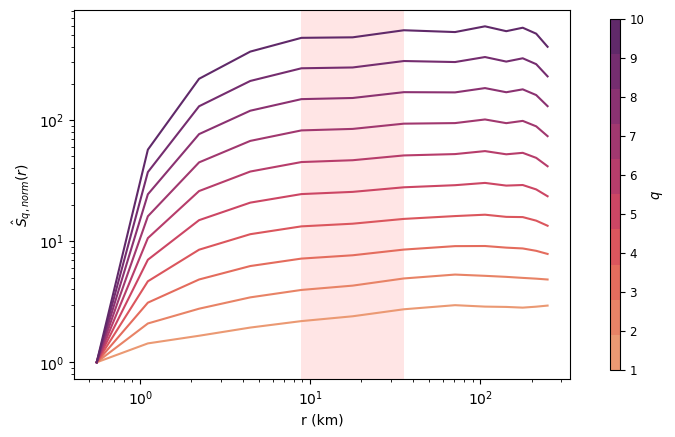

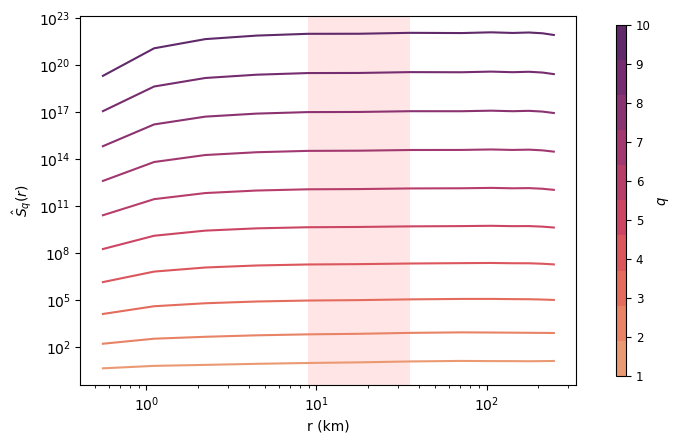

In [6]:
fig, ax = plt.subplots(1,1)
plot_moments(moments = ShallowConvMultifractals.moments['2019-12-01T17:05:05'],
             R = ShallowConvMultifractals.radii,
             Q = ShallowConvMultifractals.Q,
             fig = fig,
             ax = ax,
             fitting_range = ShallowConvMultifractals.fitting_range,
             pixel_reso = ShallowConvMultifractals.reso)

fig, ax = plt.subplots(1,1)
plot_moments(moments = ShallowConvMultifractals.moments['2019-12-01T17:05:05'],
             R = ShallowConvMultifractals.radii,
             Q = ShallowConvMultifractals.Q,
             fig = fig,
             ax = ax,
             fitting_range = ShallowConvMultifractals.fitting_range,
             normalise=False,
             pixel_reso = ShallowConvMultifractals.reso)

## IFS deep off

In [2]:
Q = np.arange(1, 11)
R = np.array([2**i for i in range(9)])

IFS_deep_off = xr.load_dataset('/work/bb1153/b382145/IFS_cycle3_9km_nemo_deep_off/OLR_hz9o_2D_hourly_202009_remap_0.1x0.1_tropics.nc')

In [3]:
IFSMultifractals = Multifractals(input_dataset=IFS_deep_off,
                                  input_field="OLR",
                                  reso=0.05,
                                  radii=R,
                                  fitting_range=(16,64),
                                  Q=Q)

In [4]:
IFSMultifractals.multifractal_analysis(longitude_bounds=(360-130, 360-20),
                                       time_bounds=(IFS_deep_off.time[0].values, IFS_deep_off.time[48].values))

In [5]:
IFSMultifractals.compute_diurnal_parameters(bootstrap=True, n_bootstrap = 10)

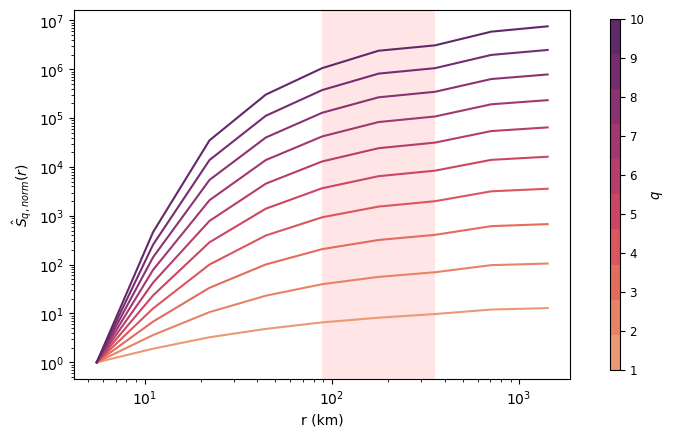

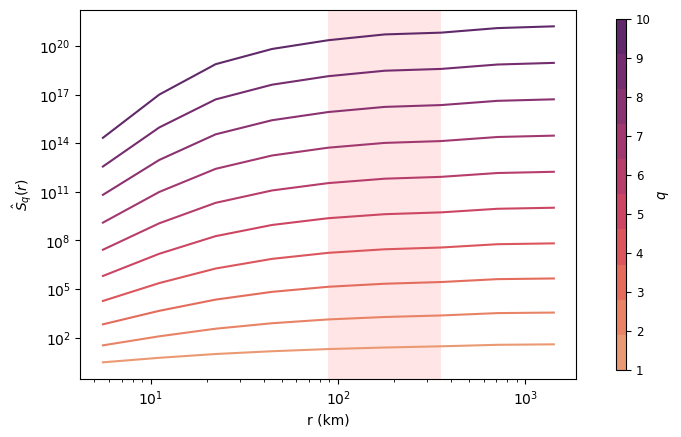

In [6]:
fig, ax = plt.subplots(1,1)
plot_moments(moments = IFSMultifractals.moments['2020-09-01T20:00:00'],
             R = IFSMultifractals.radii,
             Q = IFSMultifractals.Q,
             fig = fig,
             ax = ax,
             fitting_range = IFSMultifractals.fitting_range,
            )

fig, ax = plt.subplots(1,1)
plot_moments(moments = IFSMultifractals.moments['2020-09-01T20:00:00'],
             R = IFSMultifractals.radii,
             Q = IFSMultifractals.Q,
             fig = fig,
             ax = ax,
             fitting_range = IFSMultifractals.fitting_range,
             normalise=False)

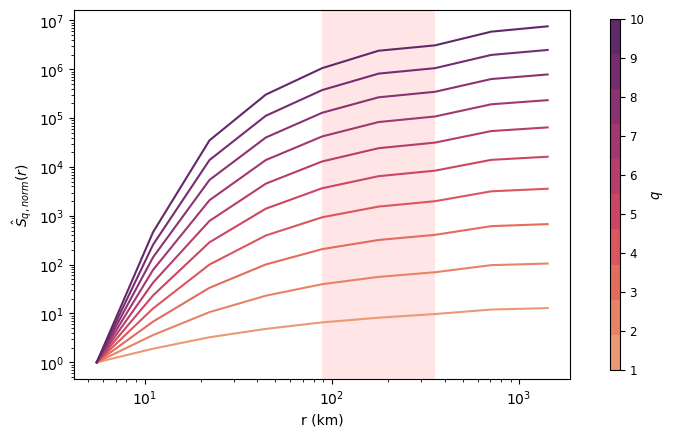

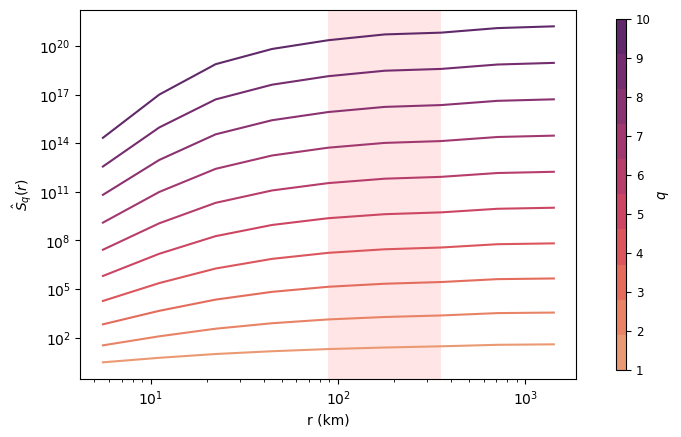

In [7]:
fig, ax = plt.subplots(1,1)
plot_moments(moments = IFSMultifractals.moments['2020-09-01T20:00:00'],
             R = IFSMultifractals.radii,
             Q = IFSMultifractals.Q,
             fig = fig,
             ax = ax,
             fitting_range = IFSMultifractals.fitting_range,
            )

fig, ax = plt.subplots(1,1)
plot_moments(moments = IFSMultifractals.moments['2020-09-01T20:00:00'],
             R = IFSMultifractals.radii,
             Q = IFSMultifractals.Q,
             fig = fig,
             ax = ax,
             fitting_range = IFSMultifractals.fitting_range,
             normalise=False)

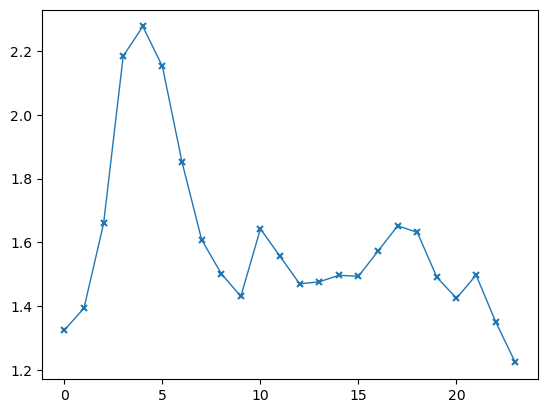

In [18]:
plt.plot(IFSMultifractals.diurnal_zeta_infinity.keys(),
         IFSMultifractals.diurnal_zeta_infinity.values(),
        '-x', markersize=4, markeredgewidth=1.5, linewidth=1)

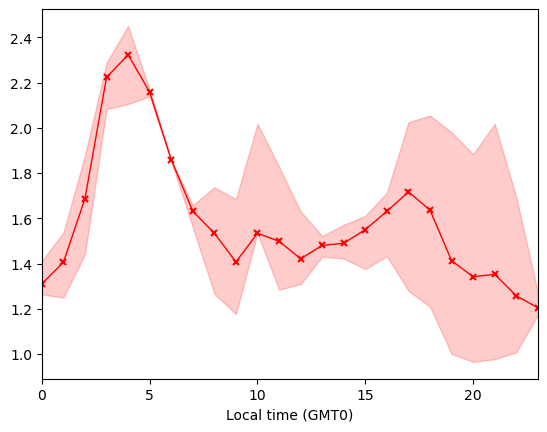

In [9]:
from multifractal_utils import plot_diurnal_bootstrap
fig, ax = plt.subplots(1,1)

# TODO: store diurnal zi and a in separate class attributes?
diurnal_zi = {hour: val['zeta_infinity'] for hour, val in IFSMultifractals.diurnal_parameters.items()}

plot_diurnal_bootstrap(diurnal_zi, IFSMultifractals.diurnal_zi_bounds,
                       ax, color = 'red', label='ifs deep off', conf = '95', GMT_delta = 0)